In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
nevs                   = 10
topk                   = 3
ϵ                      = 0.003
num_steps              = 200
t₀                      = 0.6    # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-9
solver                 = OrdinaryDiffEq.BS5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [6]:
M = assembleMassMatrix(ctx);

In [7]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀)
nothing

 29.734306 seconds (64.98 M allocations: 3.712 GiB, 3.46% gc time)


In [8]:
evs = zeros(num_steps+1,nevs)
evs[Int(num_steps/2 +1),:] , _ = eigs(K, M, nev=nevs, which=:SM);

In [9]:
for i in 1:(num_steps/2)
    DTϵ(x) = linearized_flow_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ)
    DTminusϵ(x) = linearized_flow_autodiff(y -> T(y,-i*ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    @time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ)
    evs[Int(num_steps/2 +1+i),:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    evs[Int(num_steps/2 +1-i),:], _ = eigs(Kminusϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,Int(num_steps/2), "\n")
end
nothing

 17.466508 seconds (27.34 M allocations: 1.528 GiB, 2.00% gc time)
 18.057819 seconds (27.34 M allocations: 1.527 GiB, 1.60% gc time)
1/100
 14.540470 seconds (18.74 M allocations: 1.106 GiB, 1.37% gc time)
 15.460009 seconds (18.74 M allocations: 1.106 GiB, 1.39% gc time)
2/100
 14.753443 seconds (18.74 M allocations: 1.106 GiB, 1.36% gc time)
 15.325304 seconds (18.74 M allocations: 1.106 GiB, 1.22% gc time)
3/100
 14.723791 seconds (18.74 M allocations: 1.106 GiB, 1.22% gc time)
 15.295586 seconds (18.74 M allocations: 1.106 GiB, 1.45% gc time)
4/100
 15.130601 seconds (18.74 M allocations: 1.106 GiB, 2.76% gc time)
 15.087911 seconds (18.74 M allocations: 1.106 GiB, 1.78% gc time)
5/100
 14.496929 seconds (18.74 M allocations: 1.106 GiB, 0.78% gc time)
 14.810419 seconds (18.74 M allocations: 1.106 GiB, 0.76% gc time)
6/100
 14.448306 seconds (18.74 M allocations: 1.106 GiB, 0.73% gc time)
 14.654079 seconds (18.74 M allocations: 1.106 GiB, 0.72% gc time)
7/100
 14.565675 seconds (

 11.468579 seconds (18.74 M allocations: 1.106 GiB, 0.95% gc time)
59/100
 18.223995 seconds (18.74 M allocations: 1.106 GiB, 0.67% gc time)
 11.427310 seconds (18.74 M allocations: 1.106 GiB, 0.98% gc time)
60/100
 18.322580 seconds (18.74 M allocations: 1.106 GiB, 0.61% gc time)
 11.349614 seconds (18.74 M allocations: 1.106 GiB, 1.02% gc time)
61/100
 18.729573 seconds (18.74 M allocations: 1.106 GiB, 2.52% gc time)
 11.227087 seconds (18.74 M allocations: 1.106 GiB, 1.08% gc time)
62/100
 18.452509 seconds (18.74 M allocations: 1.106 GiB, 0.63% gc time)
 11.207321 seconds (18.74 M allocations: 1.106 GiB, 1.06% gc time)
63/100
 18.522813 seconds (18.74 M allocations: 1.106 GiB, 0.66% gc time)
 11.113022 seconds (18.74 M allocations: 1.106 GiB, 1.16% gc time)
64/100
 18.540349 seconds (18.74 M allocations: 1.106 GiB, 0.66% gc time)
 11.098618 seconds (18.74 M allocations: 1.106 GiB, 1.17% gc time)
65/100
 18.680938 seconds (18.74 M allocations: 1.106 GiB, 0.64% gc time)
 11.038254 se

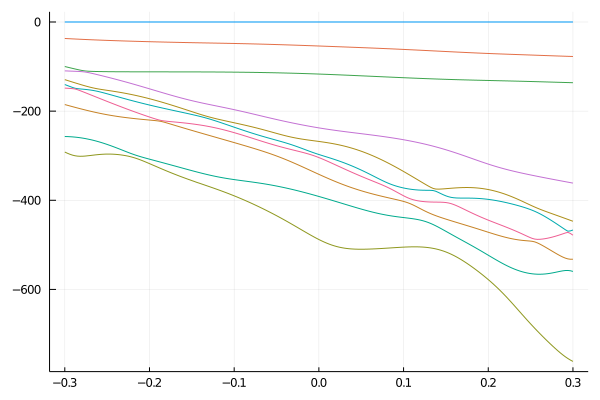

In [10]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs, legend=false, fmt = :png)

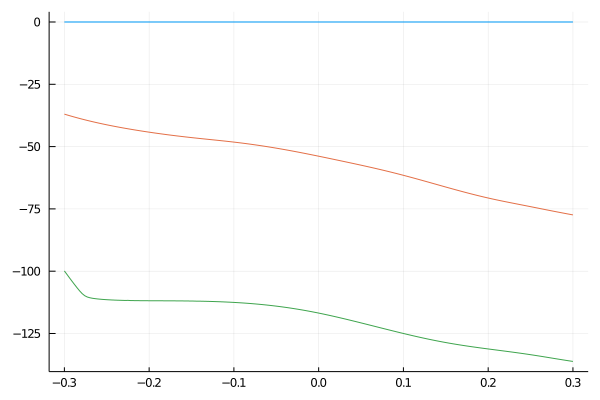

In [11]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,1:topk], legend=false, fmt = :png)

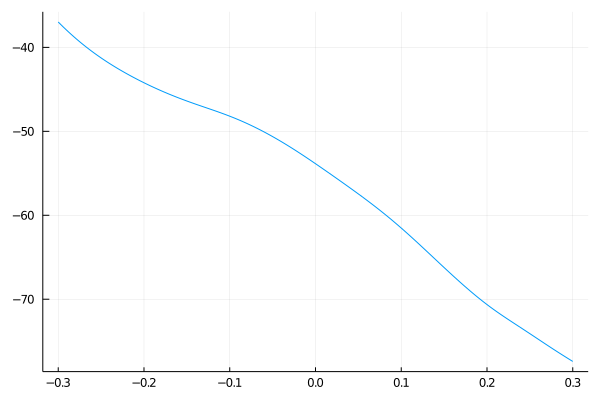

In [14]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2], legend=false, fmt = :png)

In [12]:
using DelimitedFiles

In [13]:
writedlm("D:/gyre_eigenvalues_n="*string(grid_resolution)*"_tol="*string(solver_tolerance)*
        "_qo="*string(quadrature_order)*"_solver="*string(solver)*"_method=CG.csv",
        [range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs], ",")